In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.preprocessing import SNV, MSC, SavitzkyGolay, Detrend
from pptoolbox.visualization import (plot_spectra, plot_loadings, plot_scree, fit_pca,
                                               generate_pc_df, plot_svp, initialize_theme,spectral_vector_properties)

from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

# plotly.offline.init_notebook_mode()
# qualitative_cmap, diverging_cmap, light_cmap = initialize_theme()

# import data

In [12]:
pulldate = "250218"

datafolder_path = Path ("../data/")
raw_csv = datafolder_path / f"raw/spectra_{pulldate}.csv"
spectra_df = pd.read_csv(raw_csv)

label_csv = datafolder_path / f"processed/label_{pulldate}.csv"
info_df = pd.read_csv(label_csv)

spectra_df.shape, info_df.shape

((3964, 13), (782, 23))

In [15]:
info_df = info_df.set_index(['lot_id','lot_name']).drop(columns=['Sensory Result'])

deo_info_df = info_df.select_dtypes(include='object')[info_df['Deodorization Level']=='Deodorized'].reset_index().drop(columns=['Deodorization Level','lot_name'])
deo_info_df = pd.merge(deo_info_df, info_df.select_dtypes(include='float64'), on='lot_id')
deo_info_df = deo_info_df.set_index('lot_id')

nondeo_info_df = info_df.select_dtypes(include='object')[info_df['Deodorization Level']=='Non-Deodorized'].reset_index().drop(columns=['Deodorization Level','lot_name'])
nondeo_info_df = pd.merge(nondeo_info_df, info_df.select_dtypes(include='float64'), on='lot_id')
nondeo_info_df = nondeo_info_df.set_index('lot_id')

print(deo_info_df.shape, nondeo_info_df.shape)

(248, 19) (534, 19)


In [16]:
datasets = {
    'full': {
        'info_df_og': info_df.reset_index().drop(columns=['lot_name']).set_index('lot_id')
    },
    # 'deo': {
    #     'info_df_og': deo_info_df
    # },
    'nondeo': {
        'info_df_og': nondeo_info_df
    }
}

# select params with minority class > 5%

In [17]:
# Function to filter columns
def filter_columns(df, threshold=0.05):
    row_count = len(df)
    cols_to_drop = []
    
    for col in df.columns:
        if df[col].dtype != 'object':
            continue
        value_counts = df[col].value_counts(normalize=True)  # Get class proportions
        if len(value_counts) == 1 or value_counts.min() < threshold:  # Only one unique value or minority < 5%
            cols_to_drop.append(col)
    
    return df.drop(columns=cols_to_drop), cols_to_drop

for dataset in datasets:
    if dataset == 'full':
        datasets[dataset]['info_df_cut'] = datasets[dataset]['info_df_og']
    else:
        datasets[dataset]['info_df_cut'], datasets[dataset]['dropped_cols'] = filter_columns(datasets[dataset]['info_df_og'])
        print(f"Columns dropped for {dataset}: {datasets[dataset]['dropped_cols']}")

Columns dropped for nondeo: []


# preprocess lots

In [18]:
datasets['full'].keys()

dict_keys(['info_df_og', 'info_df_cut'])

In [19]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    info_df_copy = datasets[dataset]['info_df_cut'].reset_index()
    raw_df, label_df = preprocess(spectra_df, info_df_copy, wavelengths = WAVELENGTHS_3NM_V1)

    datasets[dataset]['raw_df'] = raw_df
    datasets[dataset]['label_df'] = label_df

Processing full dataset
Processing nondeo dataset


In [20]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    label_df = datasets[dataset]['info_df_cut']

    param_label_map = {}

    for col in label_df.columns:
        if label_df[col].dtype == 'float64':
            param_label_map[col] = 'reg'
        elif label_df[col].dtype == 'object':
            param_label_map[col] = 'clf'

    datasets[dataset]["param_label_map"] = param_label_map

Processing full dataset
Processing nondeo dataset


In [21]:
for dataset in datasets:
    print(datasets[dataset]['param_label_map'])

{'Acetic': 'clf', 'Ash': 'clf', 'Astringent': 'clf', 'Bitter': 'clf', 'Brown Fruit': 'clf', 'Cacao (Chocolate)': 'clf', 'Carbon': 'clf', 'Deodorization Level': 'clf', 'Earthy': 'clf', 'Fishy': 'clf', 'Heated Fat (Oil)': 'clf', 'Musty': 'clf', 'Oxidized (Old Butter-Stale-Cardboard)': 'clf', 'Painty (Solvent-Chemical)': 'clf', 'Petroleum (Motor Oil-Rubber)': 'clf', 'Putrid': 'clf', 'Smoky': 'clf', 'Sour': 'clf', 'Straw (Hay)': 'clf', 'Sensory Value': 'reg'}
{'Acetic': 'clf', 'Ash': 'clf', 'Astringent': 'clf', 'Bitter': 'clf', 'Brown Fruit': 'clf', 'Cacao (Chocolate)': 'clf', 'Carbon': 'clf', 'Earthy': 'clf', 'Fishy': 'clf', 'Heated Fat (Oil)': 'clf', 'Musty': 'clf', 'Oxidized (Old Butter-Stale-Cardboard)': 'clf', 'Painty (Solvent-Chemical)': 'clf', 'Petroleum (Motor Oil-Rubber)': 'clf', 'Putrid': 'clf', 'Smoky': 'clf', 'Sour': 'clf', 'Straw (Hay)': 'clf', 'Sensory Value': 'reg'}


# filter data

In [22]:
# create a new dict selections to only have deo and nondeo datasets
selections = datasets.copy()

# Check for Outliers

In [23]:
cmap=sns.color_palette()
PREPROCESSING = 'No Preprocessing'

Processing full dataset
Processing nondeo dataset


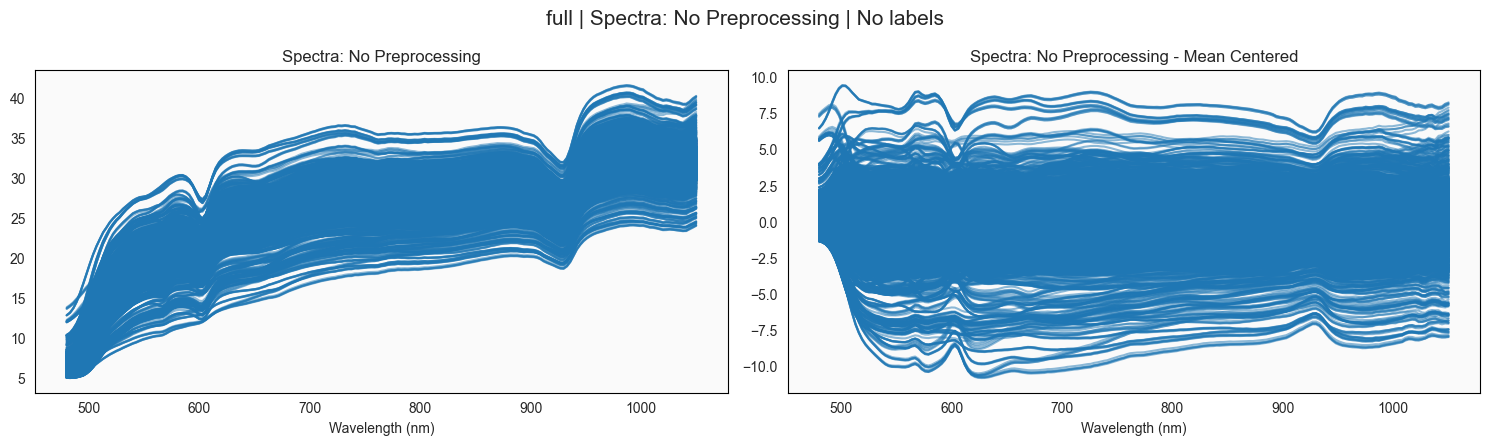

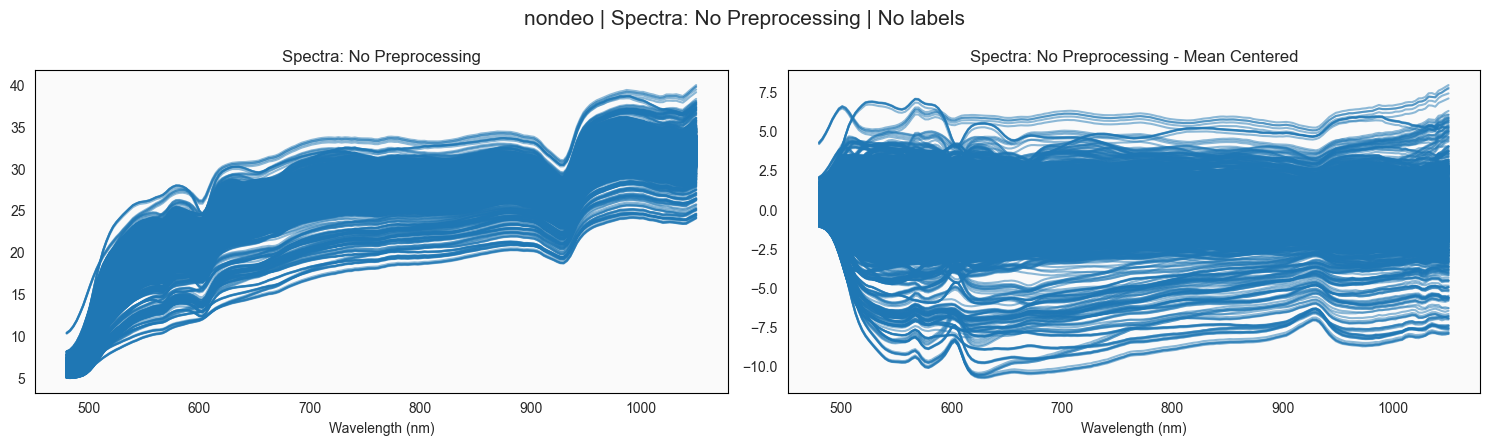

In [24]:
for selection in selections:
    print(f'Processing {selection} dataset')

    output_dir = Path(f"../data/visualisation/{selection}/")
    output_dir.mkdir(exist_ok=True, parents=True)

    selected_df = selections[selection]['raw_df']
    SAMPLE_TYPE = f'{selection}'

    plot_spectra(selected_df, labels=None,
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                cmap=cmap);

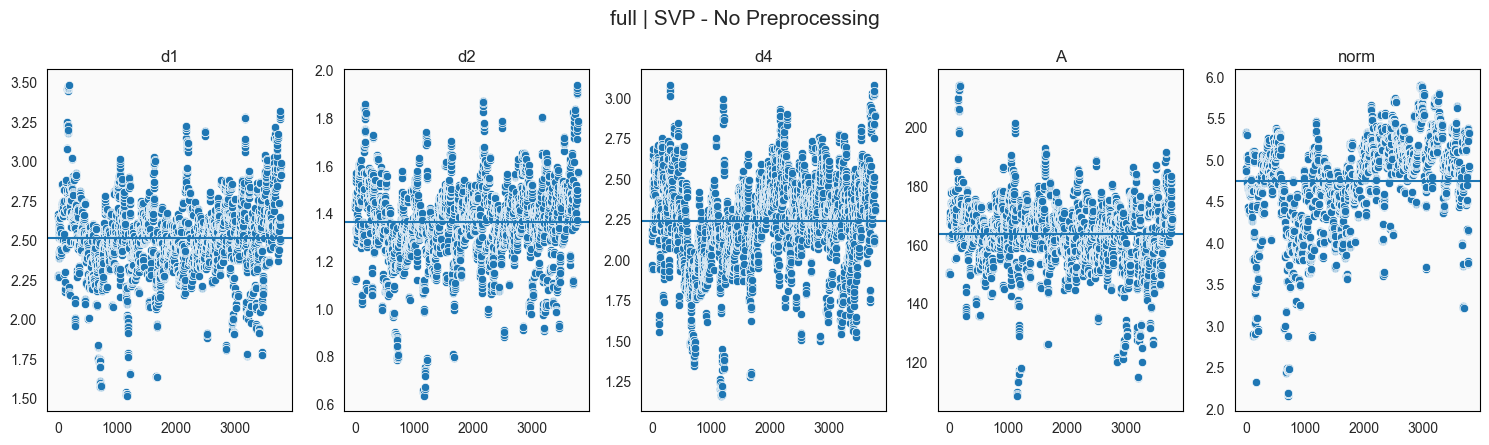

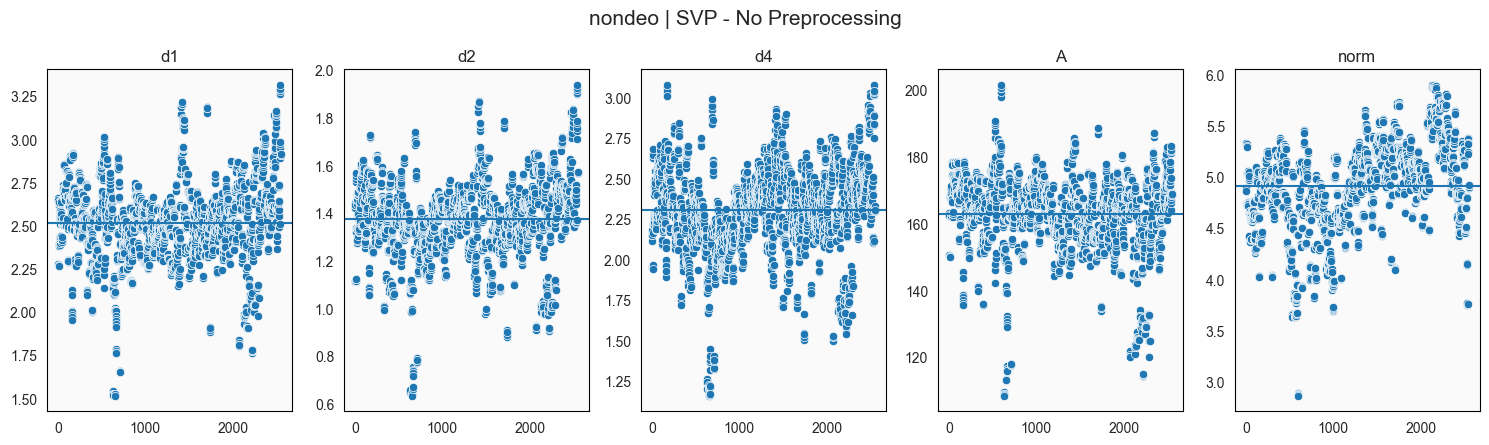

In [25]:
for selection in selections:
    
    selected_df = selections[selection]['raw_df']
    SAMPLE_TYPE = f'{selection}'
    plot_svp(selected_df, title=f'{selection} | SVP - No Preprocessing')
    plt.show()
    plt.close()

## identify outlier samples

nondeo seems to have a outlier sample

Skipping full dataset
False    2549
True        5
Name: norm, dtype: int64
Number of samples outside the range: 5


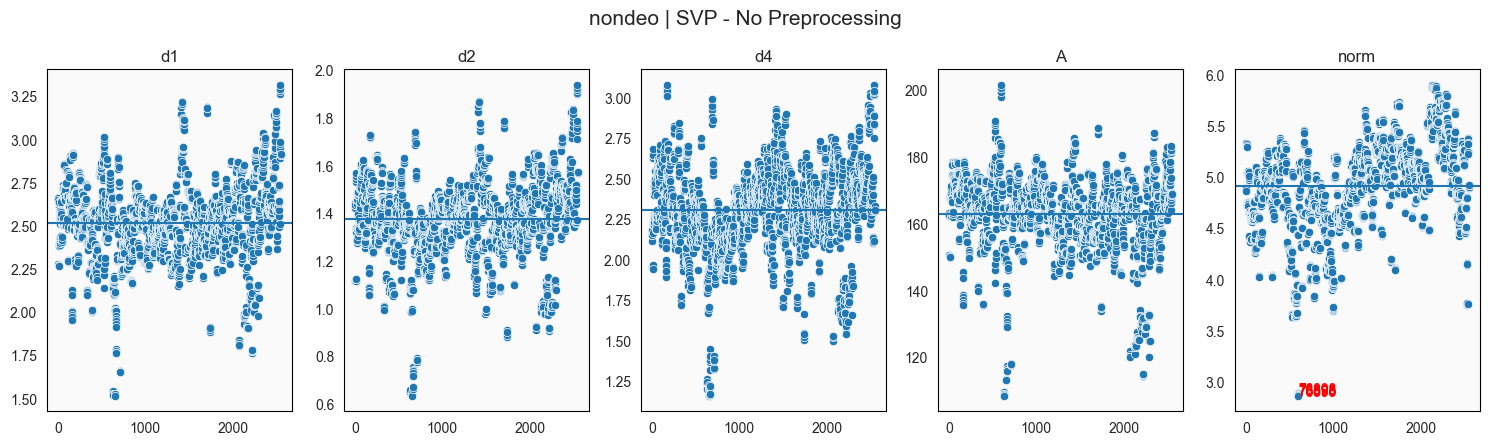

In [ ]:
for selection in selections:

    output_dir = Path(f"../data/visualisation/{selection}/")
    output_dir.mkdir(exist_ok=True, parents=True)

    if selection != "nondeo":
        print(f"Skipping {selection} dataset")
        continue

    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']

    plot_svp(selected_df, title=f'{selection} | SVP - No Preprocessing')

    svp_arr = spectral_vector_properties(selected_df, True)

    #metrics cutoff
    metrics = {
        0 : 'd1',
        1 : 'd2',
        2 : 'd4',
        3 : 'A',
        4 : 'norm'
    }
    choice = 4
    maxval = 8
    minval = 3

    norm_data = svp_arr[metrics[choice]]

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval)
    print(anomalous_mask.value_counts())

    norm_ax = plt.gcf().axes[choice]

    count = 0

    for idx in range(len(norm_data)):
        if norm_data.iloc[idx] < minval or norm_data.iloc[idx] > maxval:  
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='red')
            count += 1

    print(f"Number of samples outside the range: {count}")
            
    plt.savefig(output_dir / f"{selection}_svp.png")
    plt.show()
    plt.close()

Processing full dataset
(3787, 191) (3787, 20)
Skipping full dataset
Processing nondeo dataset
(2554, 191) (2554, 19)
False    2549
True        5
Name: norm, dtype: int64


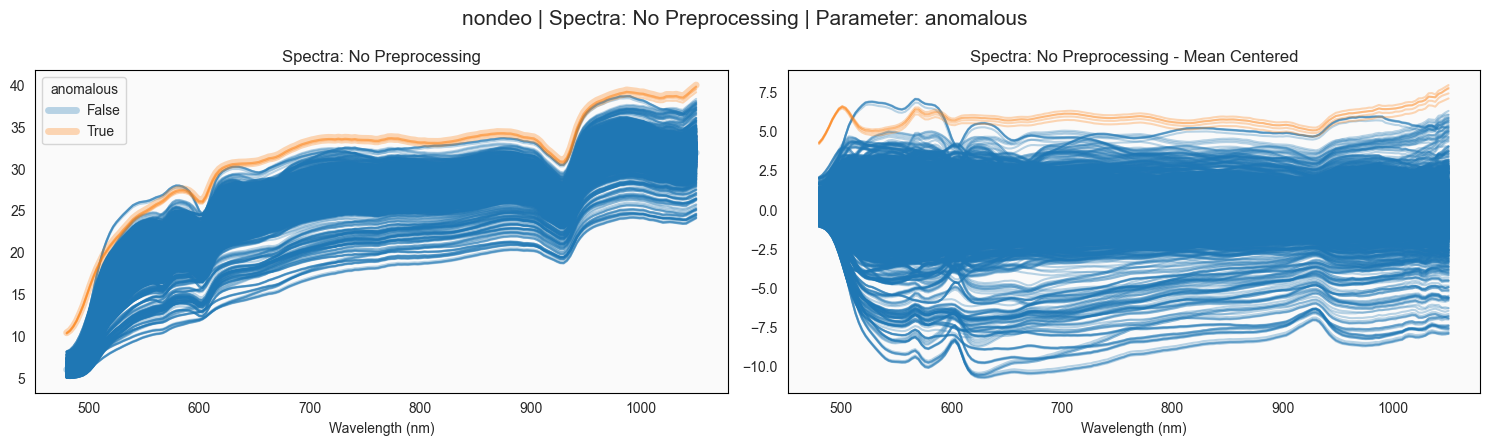

In [27]:
for selection in selections:
    SAMPLE_TYPE = f'{selection}'

    print(f'Processing {selection} dataset')
    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']
    print(selected_df.shape, selected_labels.shape)

    if selection != "nondeo":
        print(f"Skipping {selection} dataset")
        continue

    svp_arr = spectral_vector_properties(selected_df, True)

    metrics = {
        0 : 'd1',
        1 : 'd2',
        2 : 'd4',
        3 : 'A',
        4 : 'norm'
    }
    choice = 4
    maxval = 8
    minval = 3

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval)
    print(anomalous_mask.value_counts())

    # add a new column in check_df to label anomalous samples
    check_df = selected_df.copy(deep=True)
    check_df['anomalous'] = anomalous_mask
    # display(check_df[check_df['anomalous'] == True])

    plot_spectra(selected_df, labels=check_df[['anomalous']],
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                cmap=cmap)
    plt.show()
    plt.close()

## filter outliers

In [28]:
for selection in selections:

    output_dir = Path(f"../data/processed/")
    output_dir.mkdir(exist_ok=True, parents=True)

    print(f'\nProcessing {selection} dataset')
    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']
    print(selected_df.shape, selected_labels.shape)

    ### no filter for other datasets
    if selection != "nondeo":
        selected_df.to_csv(output_dir/f"cleaned_input_{selection}_{pulldate}.csv")
        selected_labels.to_csv(output_dir/f"cleaned_label_{selection}_{pulldate}.csv")

        print(f"No cleaning for {selection} dataset")
        continue

    svp_arr = spectral_vector_properties(selected_df, True)

    metrics = {
        0 : 'd1',
        1 : 'd2',
        2 : 'd4',
        3 : 'A',
        4 : 'norm'
    }
    choice = 4
    maxval = 8
    minval = 3

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval)

    # add a new column in check_df to label anomalous samples
    check_df = selected_df.copy(deep=True)
    check_df['anomalous'] = anomalous_mask
    anomalous_idx = check_df[check_df['anomalous'] == True].index.unique()
    cleaned_df = selected_df.drop(index=anomalous_idx)
    cleaned_labels = selected_labels.drop(index=anomalous_idx)
    print(f'shapes after cleaning: {cleaned_df.shape} {cleaned_labels.shape}')

    cleaned_df.to_csv(output_dir/f"cleaned_input_{selection}_{pulldate}.csv")
    cleaned_labels.to_csv(output_dir/f"cleaned_label_{selection}_{pulldate}.csv")


Processing full dataset
(3787, 191) (3787, 20)
No cleaning for full dataset

Processing nondeo dataset
(2554, 191) (2554, 19)
shapes after cleaning: (2549, 191) (2549, 19)
